### Hand gesture recognition - Creative Senz3D
The dataset contains several different static gestures acquired with the Creative Senz3D camera.
http://lttm.dei.unipd.it/downloads/gesture/

In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
wk_dir = os.path.abspath(os.path.dirname('__file__'))

In [3]:
lookup = dict()
reverselookup = dict()
for i, j in enumerate(os.listdir(wk_dir + '/images/senz3D/acquisitions/S1/')):
    if not j.startswith('.'): # to not run hidden folders
        lookup[j] = i
        reverselookup[i] = j
lookup

{'G1': 0,
 'G10': 1,
 'G11': 2,
 'G2': 3,
 'G3': 4,
 'G4': 5,
 'G5': 6,
 'G6': 7,
 'G7': 8,
 'G8': 9,
 'G9': 10}

#### Bulding a dataset x_data and y_data
Since the images are quite large and are coming from an infra-red sensor, there's nothing really lost in converting them to greyscale and resizing to speed up the computations.

In [4]:
x_data, y_data = [], []
for counter, i in enumerate(range(1, 5)): # Loop over the ten top-level folders
    for j in os.listdir(wk_dir + '/images/senz3D/acquisitions/S' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            for sub_counter, k in enumerate(os.listdir(wk_dir + '/images/senz3D/acquisitions/S' + 
                                str(i) + '/' + j + '/')):
                                # Loop over the images
                # only the color images
                if k[-3:] == 'png':
                    img = Image.open(wk_dir + '/images/senz3D/acquisitions/S' + 
                                     str(i) + '/' + j + '/' + k).convert('L')
                                    # Read in and convert to greyscale
                    img = img.resize((320, 120))
                    arr = np.array(img)
                    x_data.append(arr)
            y_values = np.full((int((sub_counter + 1) / 3), 1), lookup[j]) 
            y_data.append(y_values)
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(-1, 1) # Reshape to be the correct size

In [5]:
print(x_data.shape)
print(y_data.shape)

(1320, 120, 320)
(1320, 1)


#### Displaying one image of each of the gestures

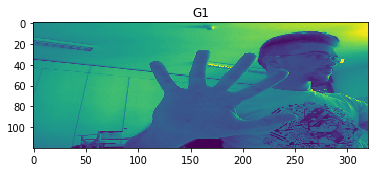

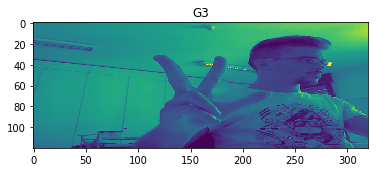

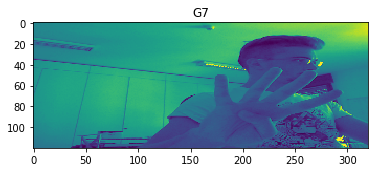

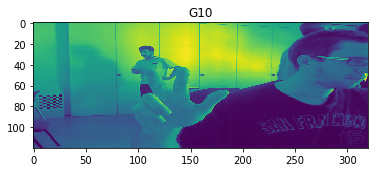

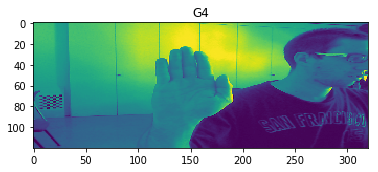

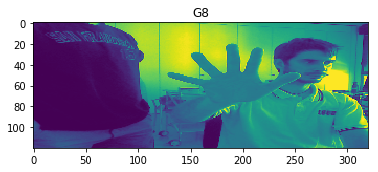

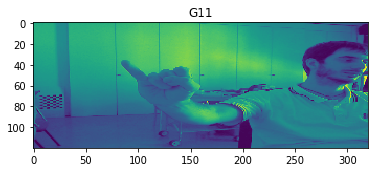

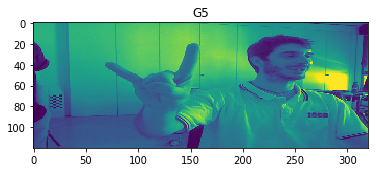

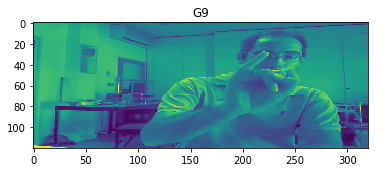

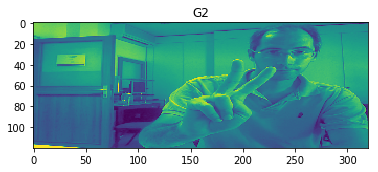

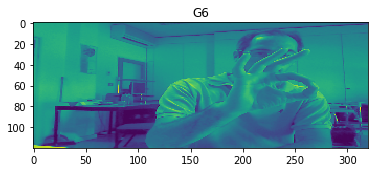

In [6]:
from random import randint


for i in range(0, 11):
    plt.imshow(x_data[i*120 + randint(0, 120), :, :])
    plt.title(reverselookup[y_data[i*120 ,0]])
    plt.show()

In [7]:
# Converting y_data to a one-hot format
import keras


y_data = keras.utils.to_categorical(y_data)
print(y_data.shape)

Using TensorFlow backend.


(1320, 11)


In [8]:
y_data[0,:]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [9]:
# x_data has to be reshaed to the format [batch, height, width, channels]
x_data = x_data.reshape((-1,120,320,1))
# and scaled to [0-1]
x_data = x_data / x_data.max()

In [10]:
from sklearn.model_selection import train_test_split


x_train,x_further,y_train,y_further = train_test_split(x_data,y_data,test_size = 0.2)
x_validate,x_test,y_validate,y_test = train_test_split(x_further,y_further,test_size = 0.5)

#### The model is built in keras

In [11]:
from keras import layers
from keras import models


model=models.Sequential()
model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(120, 320,1))) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(11, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


#### The model can be fitted

In [12]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=20, batch_size=64, verbose=1, validation_data=(x_validate, y_validate))

Instructions for updating:
Use tf.cast instead.
Train on 1056 samples, validate on 132 samples
Epoch 1/20
1056/1056 [==============================] - 5s 5ms/step - loss: 2.3954 - acc: 0.1383 - val_loss: 2.2817 - val_acc: 0.1742
Epoch 2/20
1056/1056 [==============================] - 1s 1ms/step - loss: 2.0574 - acc: 0.3011 - val_loss: 1.6849 - val_acc: 0.3561
Epoch 3/20
1056/1056 [==============================] - 1s 1ms/step - loss: 1.4575 - acc: 0.4962 - val_loss: 1.1976 - val_acc: 0.6136
Epoch 4/20
1056/1056 [==============================] - 1s 1ms/step - loss: 0.9916 - acc: 0.6657 - val_loss: 1.0873 - val_acc: 0.6515
Epoch 5/20
1056/1056 [==============================] - 1s 1ms/step - loss: 0.6542 - acc: 0.7879 - val_loss: 0.7755 - val_acc: 0.7121
Epoch 6/20
1056/1056 [==============================] - 1s 1ms/step - loss: 0.4513 - acc: 0.8475 - val_loss: 0.7818 - val_acc: 0.7273
Epoch 7/20
1056/1056 [==============================] - 1s 1ms/step - loss: 0.2896 - acc: 0.8996 - va

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


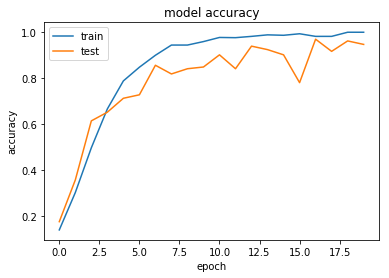

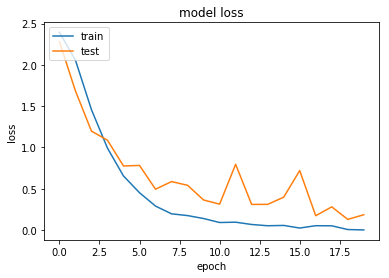

In [13]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Testing on the test set

In [14]:
[loss, acc] = model.evaluate(x_test,y_test,verbose=1)
print("Accuracy:" + str(acc))

132/132 [==============================] - 0s 540us/step
Accuracy:0.946969696969697
